In [4]:
import pandas as pd
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, roc_curve, auc, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

In [6]:
data = pd.read_csv('../processed_data.csv')

Konvertovanje atributa SalePrice u 4 kategorije

In [7]:
min_price = data['SalePrice'].min()
max_price = data['SalePrice'].max()
step = (max_price - min_price) / 4
bins = [min_price + step * i for i in range(4)] + [np.inf]
labels = ['Q1', 'Q2', 'Q3', 'Q4']
data['PriceCategory'] = pd.cut(data['SalePrice'], bins=bins, labels=labels, include_lowest=True)

Raspodela po klasama

In [8]:
df = pd.DataFrame(data)
df['PriceCategory'] = pd.cut(df['SalePrice'], bins=bins, labels=labels, include_lowest=True)

price_counts = df['PriceCategory'].value_counts()
price_counts

PriceCategory
Q2    2425
Q1    1757
Q3    1340
Q4     369
Name: count, dtype: int64

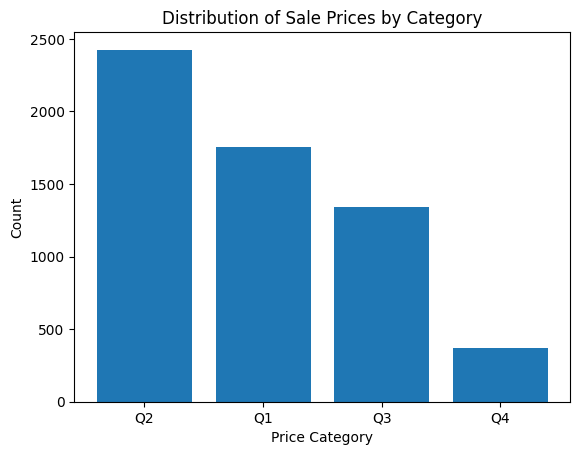

In [10]:
plt.bar(price_counts.index, price_counts.values)
plt.xlabel('Price Category')
plt.ylabel('Count')
plt.title('Distribution of Sale Prices by Category')
plt.show()

Relevant features preko Pirsonovog koeficijenta korelacije

In [11]:
correlation_matrix = data.select_dtypes(include=[np.number]).corr()
relevant_features = correlation_matrix.index[abs(correlation_matrix["SalePrice"]) > 0.5].tolist()
relevant_features

['SalePrice', 'Size(sqf)']

In [12]:
# Sklanjamo SalePrice iz relevant_features
relevant_features.remove('SalePrice') 
relevant_features

['Size(sqf)']

In [15]:
X = data[relevant_features]  
y = data['PriceCategory']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Random Forest Classifier

In [17]:
rf_model = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=3, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)
best_rf_model = rf_grid_search.best_estimator_
rf_predictions = best_rf_model.predict(X_test)
rf_metrics = classification_report(y_test, rf_predictions)
print("Random Forest Classifier Metrike:")
print(rf_metrics)

Random Forest Classifier Metrike:
              precision    recall  f1-score   support

          Q1       0.79      0.71      0.74       350
          Q2       0.62      0.83      0.71       496
          Q3       0.66      0.38      0.48       278
          Q4       0.61      0.45      0.52        55

    accuracy                           0.67      1179
   macro avg       0.67      0.59      0.61      1179
weighted avg       0.68      0.67      0.66      1179



# Gradient Boosting Classifier

In [18]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
gb_grid_search = GridSearchCV(gb_model, gb_param_grid, cv=3, scoring='accuracy')
gb_grid_search.fit(X_train, y_train)
best_gb_model = gb_grid_search.best_estimator_
gb_predictions = best_gb_model.predict(X_test)
gb_metrics = classification_report(y_test, gb_predictions)
print("Gradient Boosting Classifier Metrike:")
print(gb_metrics)

Gradient Boosting Classifier Metrike:
              precision    recall  f1-score   support

          Q1       0.79      0.71      0.74       350
          Q2       0.62      0.82      0.71       496
          Q3       0.65      0.39      0.49       278
          Q4       0.61      0.45      0.52        55

    accuracy                           0.67      1179
   macro avg       0.67      0.59      0.62      1179
weighted avg       0.68      0.67      0.66      1179



Cuvanje metrika 

In [19]:
output_dir = 'classifiers'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

with open(os.path.join(output_dir, 'random_forest_metrics.txt'), 'w') as f:
    f.write("Random Forest Classifier Metrics:\n")
    f.write(rf_metrics)

with open(os.path.join(output_dir, 'gradient_boosting_metrics.txt'), 'w') as f:
    f.write("Gradient Boosting Classifier Metrics:\n")
    f.write(gb_metrics)

print("Classification metrics su sacuvane u  'classifiers' folderu.")

Classification metrics su sacuvane u  'classifiers' folderu.


# Toplotne mape rezultata

In [20]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, subplot_index=1, fig=None):
    if fig is None:
        fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(1, 2, subplot_index)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
    return fig

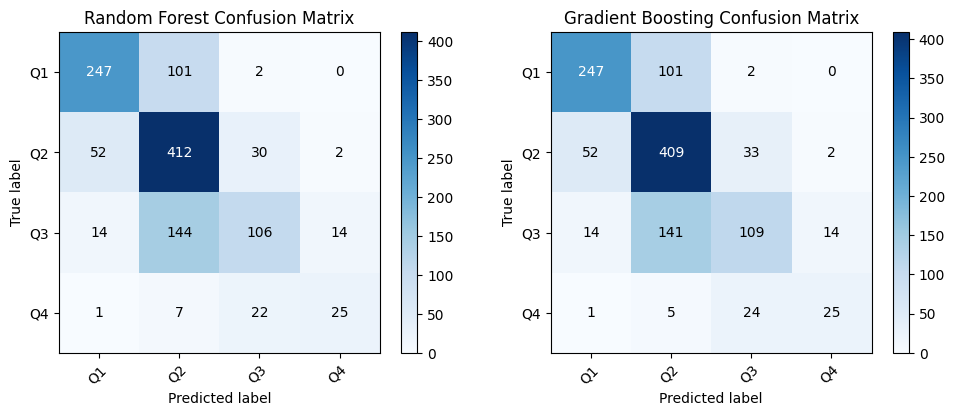

In [21]:
classes = ['Q1', 'Q2', 'Q3', 'Q4']
cm_rf = confusion_matrix(y_test, rf_predictions)
cm_gb = confusion_matrix(y_test, gb_predictions)
fig = plot_confusion_matrix(cm_rf, classes, title='Random Forest Confusion Matrix', subplot_index=1)
plot_confusion_matrix(cm_gb, classes, title='Gradient Boosting Confusion Matrix', subplot_index=2, fig=fig)
plt.tight_layout()
plt.savefig('classifiers/comparison.png', format='png', dpi=300)  # Cuvanje slike